# Exploratory data analysis & model evaluation: Wine quality data

In [ ]:
# EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import probplot

from sklearn.impute import SimpleImputer

from typing import Tuple

# Model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
import joblib

import warnings

warnings.filterwarnings("ignore")


In [ ]:
# Import raw data
raw_data = pd.read_csv("../data/winequalityN.csv")
raw_data.head()

raw_data = pd.get_dummies(raw_data)
raw_data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


## Data overview

In [ ]:
raw_data.shape


(6497, 14)

In [ ]:
raw_data.dtypes


fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
type_red                  uint8
type_white                uint8
dtype: object

In [ ]:
raw_data.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type_red,type_white
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0,1


## Data cleaning

### Missing values

In [ ]:
def check_null_values(data: pd.DataFrame()) -> pd.DataFrame():
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum() / data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent * 100], axis=1, keys=["Total", "Percent"])
    return missing_data


In [ ]:
check_null_values(raw_data)


,Total,Percent
fixed acidity,10,0.153917
pH,9,0.138525
volatile acidity,8,0.123134
sulphates,4,0.061567
citric acid,3,0.046175
residual sugar,2,0.030783
chlorides,2,0.030783
free sulfur dioxide,0,0.000000
total sulfur dioxide,0,0.000000
density,0,0.000000


### Impute missing values

In [ ]:
raw_data_columns = raw_data.columns

imputer = SimpleImputer(strategy="mean")
raw_data = pd.DataFrame(imputer.fit_transform(raw_data))
raw_data.columns = raw_data_columns


In [ ]:
check_null_values(raw_data)

,Total,Percent
fixed acidity,0,0.0
volatile acidity,0,0.0
citric acid,0,0.0
residual sugar,0,0.0
chlorides,0,0.0
free sulfur dioxide,0,0.0
total sulfur dioxide,0,0.0
density,0,0.0
pH,0,0.0
sulphates,0,0.0


## Data exploration

### Feature selection

#### Correlation between variables

In [ ]:
def plot_corr_matrix(df: pd.DataFrame(), size: Tuple) -> None:
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    f, ax = plt.subplots(figsize=size)
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=0.3,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        annot=True,
        annot_kws={"size": 10},
    )
    plt.show()


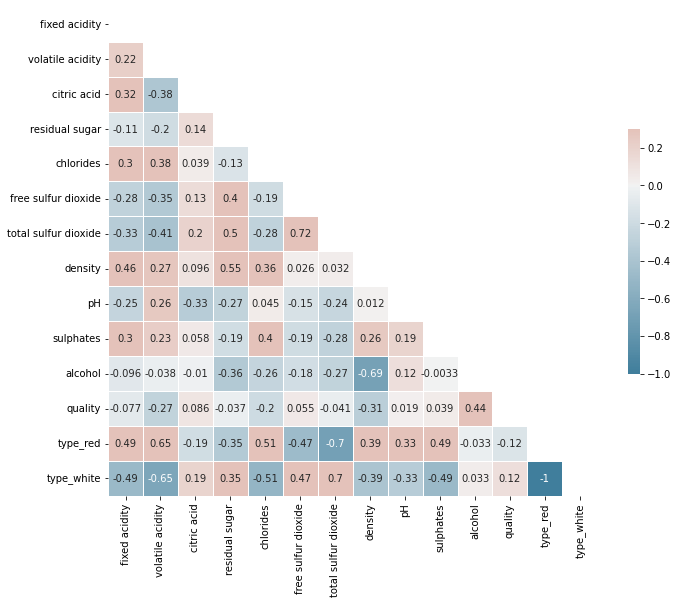

In [ ]:
plot_corr_matrix(df=raw_data, size=(11, 9))


Check for causality on correlated features:
- Volatile acidity: Refers to the acidic elements of a wine that are gaseous, rather than liquid, and therefore can be sensed as a smell.
- Chlorides: Contribute to saltiness on taste.
- Density: How grape concentrated is the wine during fermentation.
- Alchohol: How alcohol concentrated is the wine.
- Red or white: Type of wine.

It looks that all are features that cause an effect on wine quality.

In [ ]:
corr_feats = ['volatile acidity', 'chlorides', 'density', 'alcohol', 'type_red', 'type_white', 'quality']
wine_df = raw_data[corr_feats] 
wine_df.shape


(6497, 7)

### Categorical distributions

In [ ]:
def describe_categorical_feature(df: pd.DataFrame(), feature: str, size: Tuple):
    print(df[feature].describe())

    f, ax = plt.subplots(figsize=size)
    sns.countplot(y=feature, data=df)
    plt.show()


count    6497.000000
mean        5.818378
std         0.873255
min         3.000000
25%         5.000000
50%         6.000000
75%         6.000000
max         9.000000
Name: quality, dtype: float64


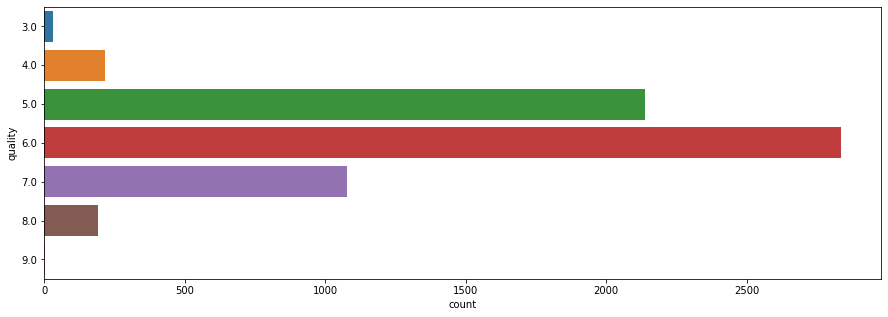

In [ ]:
describe_categorical_feature(wine_df, "quality", (15, 5))


count    6497.000000
mean        0.753886
std         0.430779
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: type_white, dtype: float64


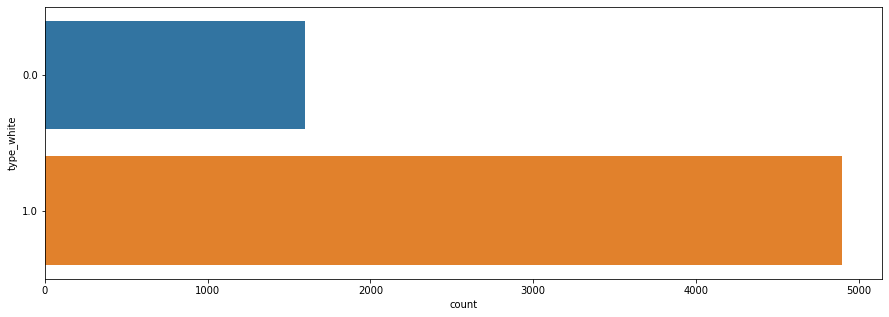

In [ ]:
describe_categorical_feature(wine_df, "type_white", (15, 5))


### Numeric distributions

In [ ]:
def feature_normality_analysis(df: pd.DataFrame(), feature: str, size: Tuple) -> None:
    print(df[feature].describe())

    # Normalized histogram
    f, ax = plt.subplots(1, 2, figsize=size)
    sns.distplot(df[feature], fit=norm, ax=ax[0]).set(
        title=f"{feature} normalized histogram"
    )

    # Probability plot
    res = probplot(df[feature], plot=ax[1])

    f.suptitle(f"{feature} normality analysis")

    plt.show()


count    6497.000000
mean        0.339691
std         0.164548
min         0.080000
25%         0.230000
50%         0.290000
75%         0.400000
max         1.580000
Name: volatile acidity, dtype: float64


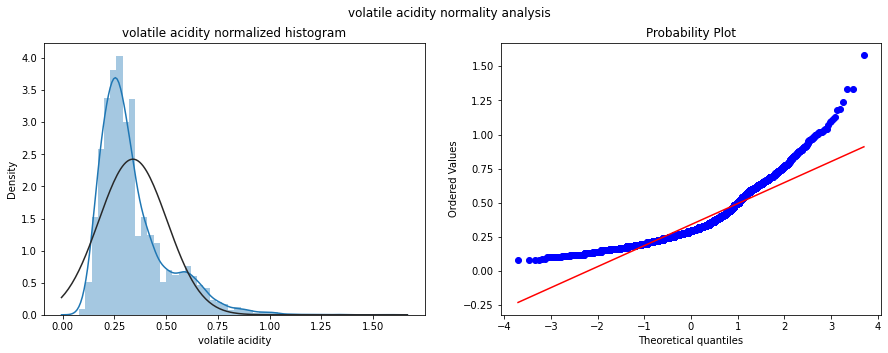

count    6497.000000
mean        0.056042
std         0.035031
min         0.009000
25%         0.038000
50%         0.047000
75%         0.065000
max         0.611000
Name: chlorides, dtype: float64


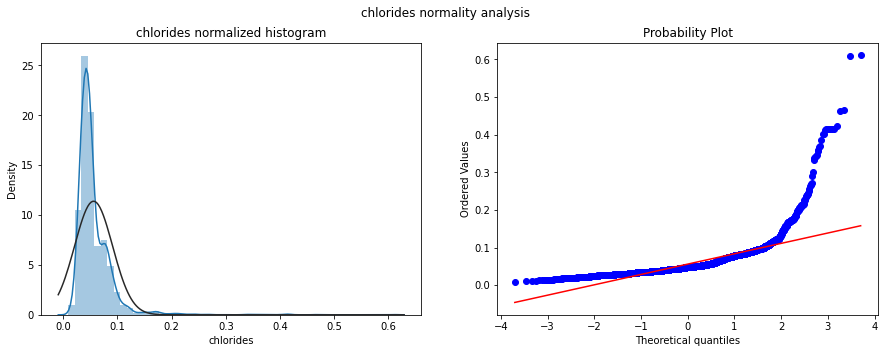

count    6497.000000
mean        0.994697
std         0.002999
min         0.987110
25%         0.992340
50%         0.994890
75%         0.996990
max         1.038980
Name: density, dtype: float64


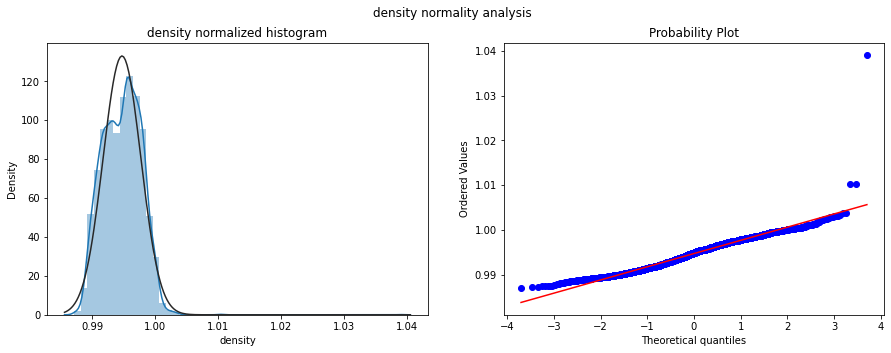

count    6497.000000
mean       10.491801
std         1.192712
min         8.000000
25%         9.500000
50%        10.300000
75%        11.300000
max        14.900000
Name: alcohol, dtype: float64


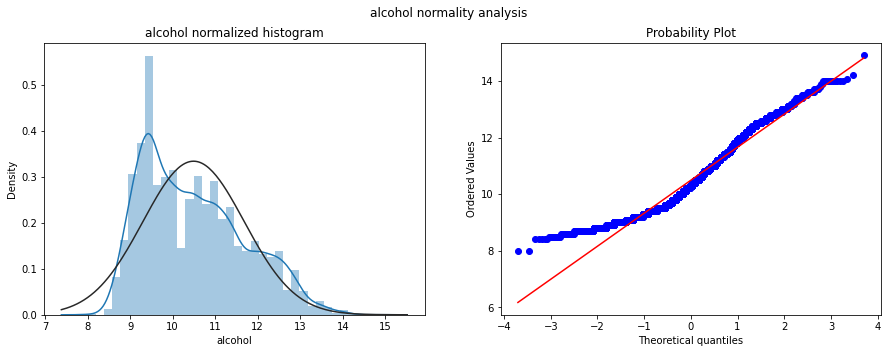

In [ ]:
num_features = ["volatile acidity", "chlorides", "density", "alcohol"]
for feature in num_features:
    feature_normality_analysis(wine_df, feature, (15, 5))


### Processing the data

#### Feature normalization

In [ ]:
wine_df["volatile acidity"] = np.log(wine_df["volatile acidity"])


count    6497.000000
mean       -1.180084
std         0.438745
min        -2.525729
25%        -1.469676
50%        -1.237874
75%        -0.916291
max         0.457425
Name: volatile acidity, dtype: float64


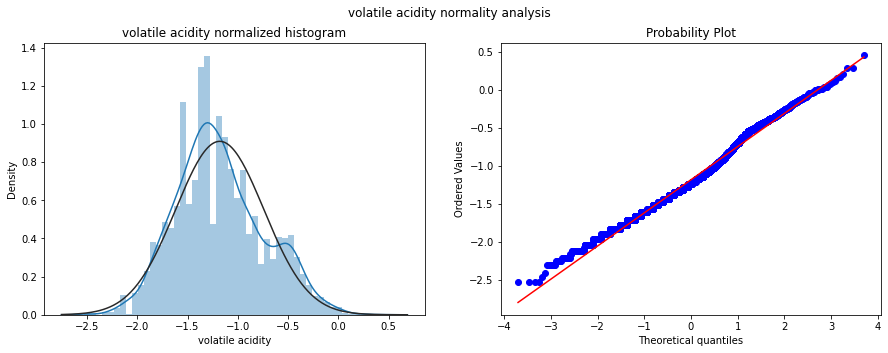

In [ ]:
feature_normality_analysis(wine_df, "volatile acidity", (15, 5))


In [ ]:
wine_df["chlorides"] = np.clip(wine_df["chlorides"], a_min=0, a_max=0.125)
wine_df["chlorides"] = np.log(wine_df["chlorides"])


count    6497.000000
mean       -3.001680
std         0.396277
min        -4.710531
25%        -3.270169
50%        -3.057608
75%        -2.733368
max        -2.079442
Name: chlorides, dtype: float64


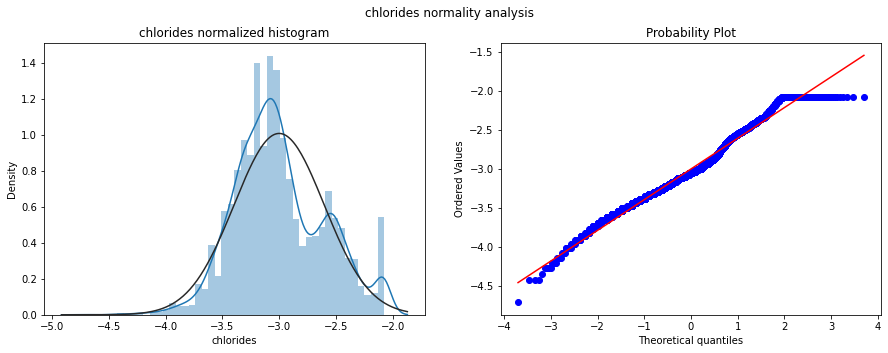

In [ ]:
feature_normality_analysis(wine_df, "chlorides", (15, 5))


In [ ]:
wine_df["density"] = np.clip(wine_df["density"], a_min=0, a_max=1.005)


count    6497.000000
mean        0.994690
std         0.002943
min         0.987110
25%         0.992340
50%         0.994890
75%         0.996990
max         1.005000
Name: density, dtype: float64


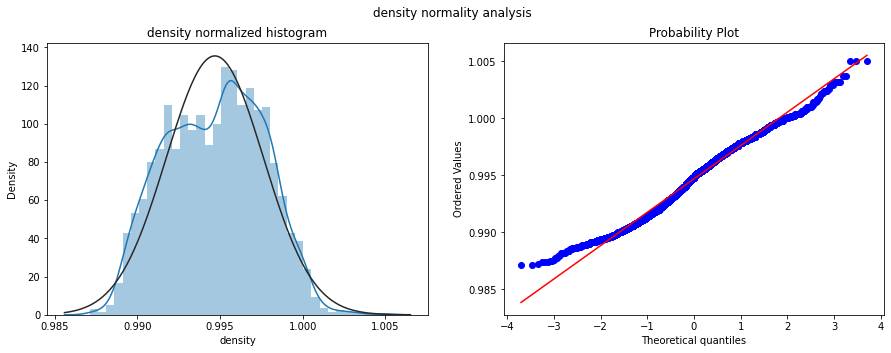

In [ ]:
feature_normality_analysis(wine_df, "density", (15, 5))


### Segment & group by the target feature

#### Segment the target by numeric features

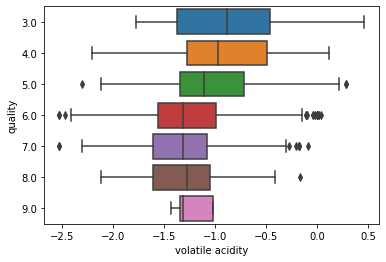

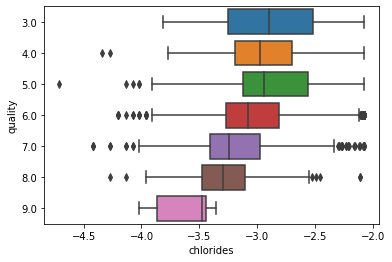

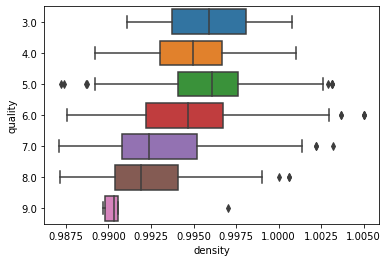

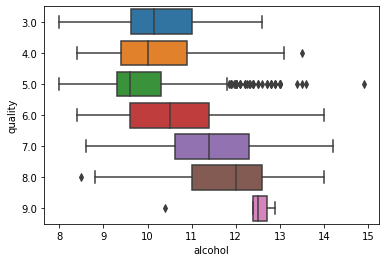

In [ ]:
for feature in num_features:
    f, ax = plt.subplots()
    sns.boxplot(y=wine_df["quality"].astype("category"), x=feature, data=wine_df)
    plt.show()


#### Segment Categorical features by the target class

##### Tabulate target across various categorical features using cross tab

In [ ]:
display(pd.crosstab(wine_df["quality"], wine_df["type_white"], normalize="index"))


type_white,0.0,1.0
quality,,
3.0,0.333333,0.666667
4.0,0.245370,0.754630
5.0,0.318522,0.681478
6.0,0.224965,0.775035
7.0,0.184430,0.815570
8.0,0.093264,0.906736
9.0,0.000000,1.000000


##### Count plot of target across various categorical features

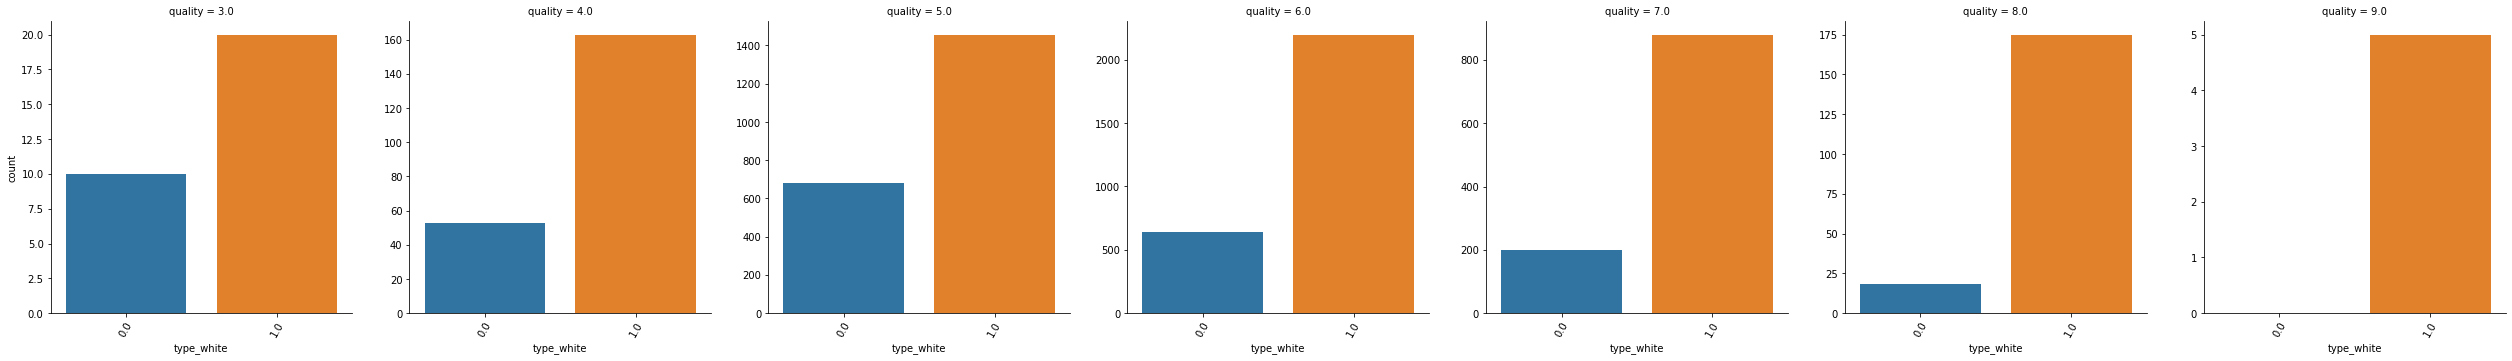

In [ ]:
g = sns.catplot(x="type_white", kind="count", col="quality", data=wine_df, sharey=False)
g.set_xticklabels(rotation=60)
plt.show()


### Group numeric features by categorical features

In [ ]:
  display(wine_df.groupby('type_white')[num_features].mean())
    

,volatile acidity,chlorides,density,alcohol
type_white,,,,
0.0,-0.698932,-2.534605,0.996747,10.422983
1.0,-1.337161,-3.154162,0.994018,10.514267


## Model

### Splitting data

In [ ]:
X = wine_df.drop("quality", axis=1)
y = wine_df.quality
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=True, random_state=128
)


### Create pipeline

In [ ]:
pipeline = Pipeline([("scaler", StandardScaler()), ("model", XGBClassifier())])


### Best params

In [ ]:
params = {
    "model__learning_rate": [0.01, 0.03, 0.1, 0.3, 1],
    "model__max_depth": [3, 6, 9],
    "model__n_estimators": [100, 500, 1000],
}
kf = KFold(n_splits=3)


In [ ]:
clf = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    scoring="neg_root_mean_squared_error",
    refit=True,
    cv=kf,
   n_jobs=-1,
    verbose=1,
)
clf.fit(X_train, y_train)
joblib.dump(clf, "../model/clf.pkl")
#clf = joblib.load("../model/clf.pkl")


Fitting 3 folds for each of 45 candidates, totalling 135 fits
[00:01:54] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


['../model/clf.pkl']

In [ ]:
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_) ** (1 / 2.0))


Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 9, 'model__n_estimators': 100}
Lowest RMSE:  0.8770817128586745


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ae136382-4641-4f46-9b46-5dc65f92ec77' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>